# Wine Consumption and Winery Density Effects on Health and Housing



* Determine which plot would best visualize each of the 4 datasets below, and build out those plots.



In [40]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from pprint import pprint

In [350]:
wine_regions_df = pd.read_csv(os.path.join("..","Data","Raw","Wine_Regions.csv"))
total_wine_producers_df = pd.read_csv(os.path.join("..","Data","Clean",
                                                   "bonded_wine_producers_by_state_1999_june_2019_clean.csv"))
state_abbrevs = pd.read_csv(os.path.join("..","Data","Raw","state_abbrevs.csv"))

In [386]:
# wine_regions_df.sort_values("Vineyards", ascending=False).head(10)["Vineyards"]
total_wine_producers_df.fillna(0, inplace=True)
state_abbrevs = pd.read_csv(os.path.join("..","Data","Raw","state_abbrevs.csv"))
state_abbrevs.rename(columns={"State Name": "STATENAME"}, inplace=True)

In [387]:
state_abbrevs.head()

,STATENAME,STATE
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [388]:
total_wine_producers_df = total_wine_producers_df.merge(state_abbrevs, on="STATE", how="outer")


In [402]:
total_wine_producers_df.loc[total_wine_producers_df["STATENAME"]=="California",crash_years]

,2010,2011,2012,2013,2014,2015,2016,2017,2018
4,3021.0,3540.0,3754.0,4061.0,4285.0,4416.0,4653.0,4836,5217


In [27]:
top_vineyards = wine_regions_df.sort_values("Vineyards",ascending=False).\
head(20)[["Region Name","Vineyards"]]
top_vineyards["Region Name"]

88              North Coast
90          Northern Sonoma
162       Willamette Valley
139            Sonoma Coast
22            Central Coast
112    Russian River Valley
87              Napa Valley
141           Sonoma Valley
33          Columbia Valley
96              Paso Robles
1          Alexander Valley
42         Dry Creek Valley
25       Chehalem Mountains
83                 Monterey
143         Southern Oregon
57             Green Valley
49       Eola - Amity Hills
158      Walla Walla Valley
56             Grand Valley
165         Yamhill-Carlton
Name: Region Name, dtype: object

([<matplotlib.axis.XTick at 0x20ad83fb198>,
 <a list of 20 Text xticklabel objects>)

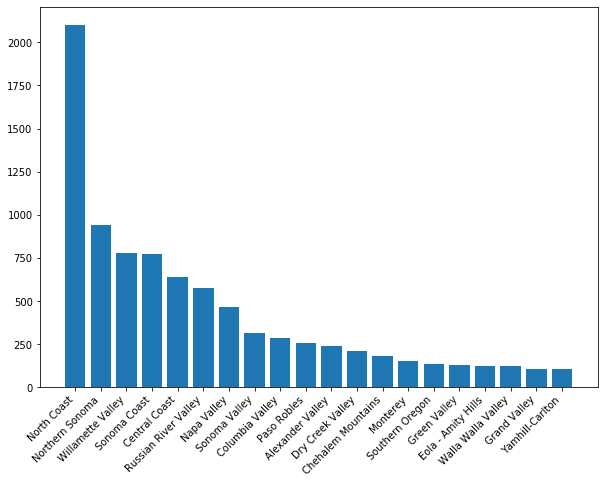

In [35]:
xticks = np.arange(20)
plt.figure(figsize=(10,7))
plt.bar(xticks, top_vineyards["Vineyards"])
plt.xticks(xticks, top_vineyards["Region Name"], rotation=45, ha="right")


In [196]:
# a single request to get the names of the columns
crash_params = \
    {
        "fromCaseYear" : "2011",
        "toCaseYear" : "2011",
        "state" : "6",
        "county" : "",
        "format": "json"
    }
response = requests.get(crashes_loc_base_url, params=crash_params).json()
crash_df = pd.DataFrame(response["Results"][0])
# removing all rows:
crash_df = crash_df.drop(crash_df.index[:])
# crash_df = crash_df.append(response["Results"][0])
crash_df.head()

,CITY,CITYNAME,COUNTY,COUNTYNAME,CaseYear,FATALS,LATITUDE,LONGITUD,STATE,STATENAME,ST_CASE,TOTALVEHICLES,TWAY_ID,TWAY_ID2,VE_FORMS


In [197]:
crashes_loc_base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByLocation?"

# the API limits the number of crashes returned to 5,000 per call. This list will store the number of
# responses per call. If that number is 5000, we'll need to split up that call to get all the crashes.
nCrashes = [None]*54
c = 0
# API codes for California, Coloarado, Idaho, Oregon, Texas, Washington: the states with the most wineries
state_ids = [6, 8, 16, 41, 48, 53]
for year in range(2010, 2019, 1):
    for state in state_ids:
        crash_params = \
        {
            "fromCaseYear" : str(year),
            "toCaseYear" : str(year),
            "state" : str(state),
            "county" : "",
            "format": "json"
        }
        
        response = requests.get(crashes_loc_base_url, params=crash_params)
        response_json = response.json()
        if response.status_code == 200:
            try:
                crash_df = crash_df.append(response_json["Results"][0])
                nCrashes[c] = len(response_json["Results"][0])
            except IndexError: 
                continue
        c += 1

In [333]:
[x for x in nCrashes if x>4999]

[]

In [377]:
crash_df.to_csv(os.path.join("..", "Data", "Raw", "crashes_top_6_wine_states_2010-2018.csv"))

In [205]:
crash_df["FATALS"] = crash_df["FATALS"].astype(int)

In [206]:
state_year_group = crash_df.groupby(["STATENAME", "CaseYear"])

In [404]:
fatals = state_year_group.sum()["FATALS"].reset_index()


In [262]:
# alcohol_consumption_per_capita_df = pd.read_csv`
state_populations = pd.read_csv(os.path.join("..","Data","Raw","state_populations_2010-2018.csv"))

In [263]:
state_populations = state_populations.set_index("STATE")


In [405]:
fatals = fatals.pivot(index="STATENAME",columns="CaseYear",values="FATALS").reset_index()
fatals_groups = fatals.groupby("STATENAME")
fatals
# fatals.head()

CaseYear,STATENAME,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,California,2720,2816,2966,3107,3102,3387,3837,3884,3563
1,Colorado,450,447,474,482,488,547,608,648,632
2,Idaho,209,167,184,214,186,216,253,245,231
3,Oregon,317,331,337,313,357,446,498,439,506
4,Texas,3023,3054,3408,3389,3536,3582,3797,3732,3642
5,Washington,460,454,438,436,462,551,536,563,546


In [271]:
state_populations.drop(["Census", "Estimates Base"], inplace=True)

In [411]:
fatal_rates = fatals.drop(fatals.index[:])
fatal_rates

CaseYear,STATENAME,2010,2011,2012,2013,2014,2015,2016,2017,2018


In [415]:
# fatals_groups.get_group("California")["FATALS"] / state_populations["California"]
fatals_groups.get_group("California").loc[:,crash_years] * 100000/ state_populations["California"]
# state_populations.head()
# fatals_groups.get_group("California")["FATALS"]
# state_populations.iloc[5, 2:]



CaseYear,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,7.288141,7.48104,7.813327,8.116335,8.031039,8.695062,9.785987,9.858031,9.007245


In [373]:
state_colors = \
{
    "California": "xkcd:sky blue",
    "Colorado": "red",
    "Idaho": "blue",
    "Oregon": "purple",
    "Texas": "xkcd:burnt orange",
    "Washington": "green"
}
crash_years = [str(x) for x in range(2010, 2019,1)]
crash_years

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [429]:
crash_years + "_fatal"

TypeError: can only concatenate list (not "str") to list

(5, 17)

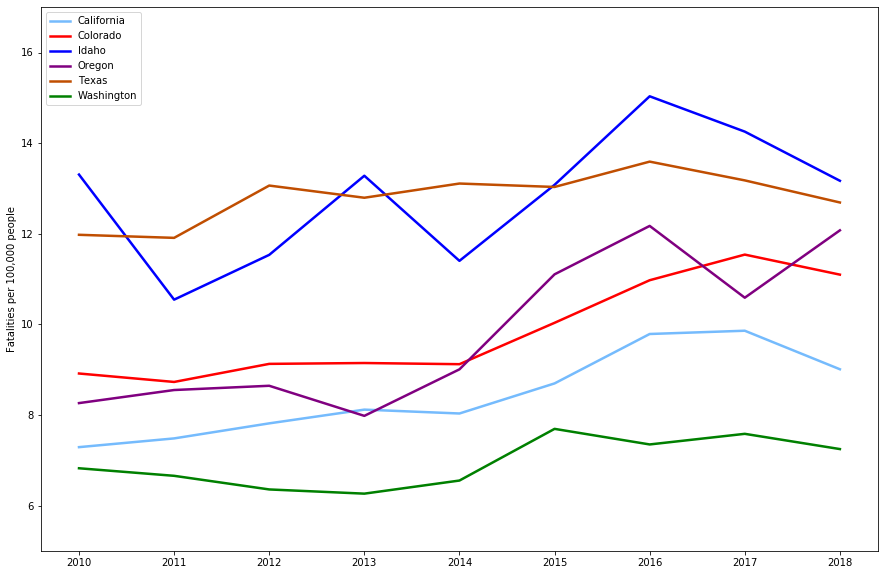

In [304]:
plt.figure(figsize=(15,10))
xticks = range(2010, 2019, 1)
for state in state_colors.keys():
    # plotting the fatality rate per 100,000 people
    plt.plot(xticks, fatals_groups.get_group(state)["FATALS"]*100000/state_populations[state],
             color = state_colors[state], label=state, linewidth=2.5)
    
plt.ylabel("Fatalities per 100,000 people")
plt.legend(loc="upper left")
plt.ylim((5,17))

In [306]:
total_wine_producers = total_wine_producers_df.transpose()
total_wine_producers.columns = total_wine_producers.iloc[0,:]
total_wine_producers.drop(total_wine_producers.index[0], inplace=True)
# top6_wine_states = total_wine_producers.loc[state_populations.index,["CA","CO","ID","OR","TX","WA"]]
top6_wine_states.rename(columns={"CA":"California","CO":"Colorado","ID":"Idaho","OR":"Oregon",
                                 "TX":"Texas","WA":"Washington"}, inplace=True)

In [367]:
top6_wine_states.head()

STATE,California,Colorado,Idaho,Oregon,Texas,Washington
2010,3021,101,47,394,211,687
2011,3540,108,53,451,280,804
2012,3754,125,59,483,330,849
2013,4061,142,65,535,383,915
2014,4285,156,67,580,439,989


In [422]:
plt.figure(figsize=(15,10))
# for state in state_colors.keys():
rate100000 = fatals_groups.get_group("California")["FATALS"]*100000/state_populations["California"]
plt.plot(top6_wine_states["California"], rate100000, color=state_colors["California"], 
            label="California", marker="o", linewidth=1)
for i, year in enumerate(top6_wine_states["California"]):
    plt.annotate(top6_wine_states["California"].index[i], (year, rate100000[i]))



KeyError: 'FATALS'

<Figure size 1080x720 with 0 Axes>

In [426]:
wine_fatal = pd.merge(total_wine_producers_df, fatals, on="STATENAME", how="outer", 
                      suffixes=("_wine","_fatal"))
wine_fatal = wine_fatal.loc[wine_fatal["STATENAME"].isin(fatals["STATENAME"]),:]

In [428]:
wine_fatal

,STATE,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,STATENAME,2010_fatal,2011_fatal,2012_fatal,2013_fatal,2014_fatal,2015_fatal,2016_fatal,2017_fatal,2018_fatal
4,CA,1364.0,1450.0,1562.0,1704.0,1869.0,2059.0,2275.0,2447.0,2687.0,...,California,2720.0,2816.0,2966.0,3107.0,3102.0,3387.0,3837.0,3884.0,3563.0
5,CO,31.0,34.0,40.0,45.0,52.0,60.0,66.0,70.0,82.0,...,Colorado,450.0,447.0,474.0,482.0,488.0,547.0,608.0,648.0,632.0
13,ID,23.0,24.0,24.0,24.0,27.0,30.0,37.0,37.0,39.0,...,Idaho,209.0,167.0,184.0,214.0,186.0,216.0,253.0,245.0,231.0
37,OR,126.0,145.0,164.0,192.0,214.0,250.0,291.0,318.0,351.0,...,Oregon,317.0,331.0,337.0,313.0,357.0,446.0,498.0,439.0,506.0
43,TX,64.0,67.0,68.0,77.0,86.0,110.0,141.0,159.0,181.0,...,Texas,3023.0,3054.0,3408.0,3389.0,3536.0,3582.0,3797.0,3732.0,3642.0
47,WA,163.0,182.0,231.0,268.0,325.0,376.0,454.0,527.0,578.0,...,Washington,460.0,454.0,438.0,436.0,462.0,551.0,536.0,563.0,546.0


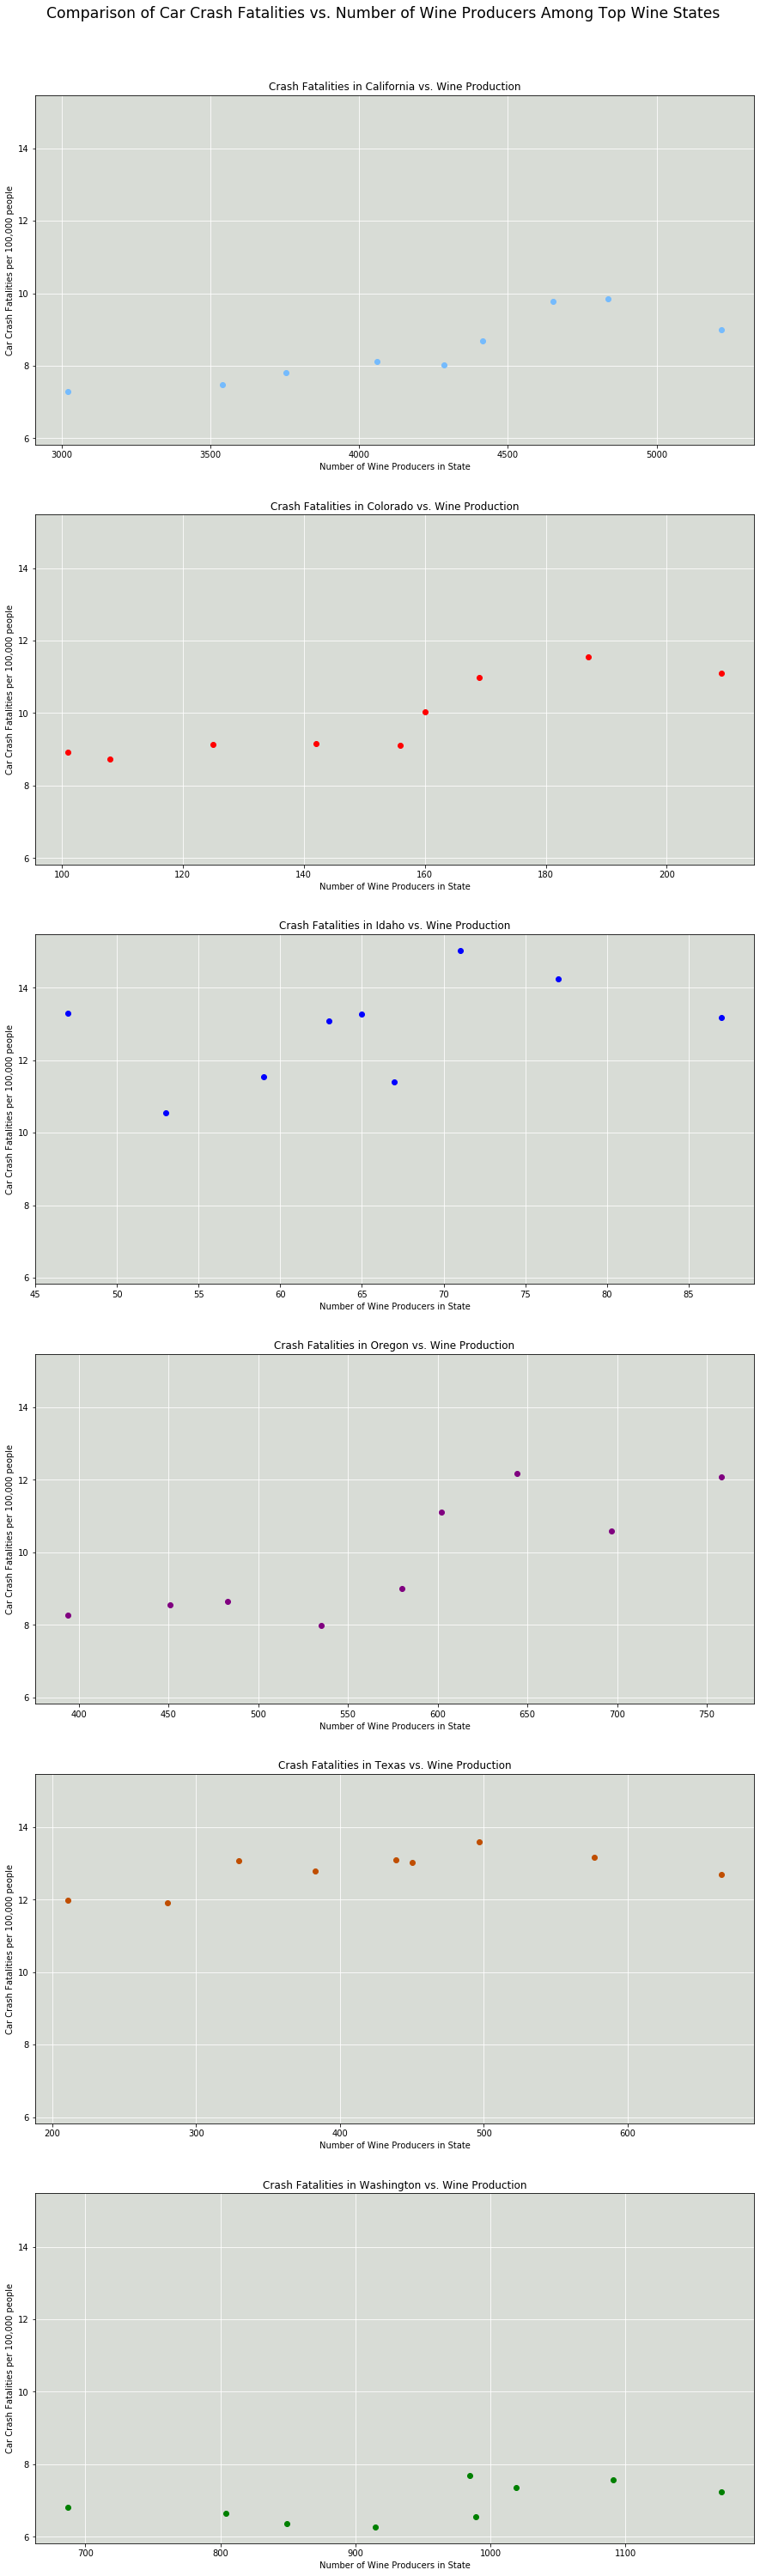

In [441]:
# Generate the Plot (with Error Bars)
fig, (p1,p2,p3,p4,p5,p6) = plt.subplots(6, sharey=True, figsize=(15,48), facecolor="w")
# fig, p = plt.plot()
# plt.figure(figsize=(15,10), facecolor="w")
# x_ticks = mean_tumor_volume_rf.index
# p1.set_xlim(min(x_ticks)*0.95, max(x_ticks)*1.05)
# p1.set_xticks(x_ticks)
# p1.set_ylim(-.1,3.8)
# p1.set_yticks(np.arange(0,3.5,.5))

# p = plt.axes()

# p.set_facecolor("xkcd:light grey")
# p.set_axisbelow(True)
# p.grid(axis="both", color = "w")
# p.title.set_text(f"Crash Fatalities vs. Wine Production")
# p.set_xlabel("Number of Wine Producers in State")
# p.set_ylabel("Car Crash Fatalities per 100,000 people")


counter = 0
for p in (p1,p2,p3,p4,p5,p6):
# for state in fatals["STATENAME"]:
    state = fatals["STATENAME"][counter]
    
    p.plot(total_wine_producers_df.loc[total_wine_producers_df["STATENAME"]==state, crash_years],
              fatals_groups.get_group(state).loc[:,crash_years] * 100000 / state_populations[state], 
              c=state_colors[state], label=state, linewidth=3, marker = "o")
#     p.errorbar(x_ticks, mean_met_sites_rf[drug], sem_met_sites_rf[drug], c=colors[drug], 
#                label=drug, elinewidth = 1)
    p.set_facecolor("xkcd:light grey")
    p.set_axisbelow(True)
    p.grid(axis="both", color = "w")

    p.title.set_text(f"Crash Fatalities in {state} vs. Wine Production")
#     p.set_xticks(x_ticks)
#     p.set_xlim(min(x_ticks)-1, max(x_ticks)+1)
    p.set_xlabel("Number of Wine Producers in State")
    p.set_ylabel("Car Crash Fatalities per 100,000 people")
    counter += 1
    
fig.suptitle("Comparison of Car Crash Fatalities vs. Number of Wine Producers Among Top Wine States",
            size="xx-large")
fig.subplots_adjust(top=.95)
# plt.annotate('Capomulin is the only drug effective in limiting the increase of Metastatic Sites', 
#              (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
